In [1]:
#%pip install --upgrade datasets

In [ ]:
#imports FreshRetail data set into Vertex AI directly from hugging face
from datasets import load_dataset
from datasets import concatenate_datasets

dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

#Combines the training and the evaluation data sets
ds_all = concatenate_datasets([dataset["train"], dataset["eval"]])
df_all = ds_all.to_pandas()

In [3]:
 #Transfers and imports the data set into my Google Cloud storage MULTI REGION bucket (Parquet)
#%pip install --quiet gcsfs pyarrow

In [4]:
import fsspec
BUCKET = "multi_region_dataset_bucket"
DEST = f"gs://{BUCKET}/freshretailnet/freshretailnet_lake_multiregion.parquet"

# --- replace if exists ---
fs = fsspec.filesystem("gcs")     # uses your GCP creds
if fs.exists(DEST):
    fs.rm(DEST)                   # delete existing object

# Write Parquet directly to GCS
df_all.to_parquet(DEST, index=False, engine="pyarrow") # writes Parquet directly to GCS

In [5]:
# pip install google-cloud-bigquery pyarrow --quiet  # run once if needed

from google.cloud import bigquery

PROJECT = "data-science-portfolio-project"
client = bigquery.Client(project=PROJECT)

# ---------------------------
# 1) LOAD DATA INTO STAGING
# ---------------------------
table_id = (
    "data-science-portfolio-project."
    "Multi_us_region_datasets.freshretail_parquet_staging_multi_region"
)

uris = [
    "gs://multi_region_dataset_bucket/freshretailnet/freshretailnet_lake_multiregion.parquet"
]

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.PARQUET,
    # Match LOAD DATA behavior (append). Use WRITE_TRUNCATE if you want replace.
    write_disposition=bigquery.WriteDisposition.WRITE_APPEND,
)

load_job = client.load_table_from_uri(uris, table_id, job_config=job_config)
load_job.result()  # wait for the load to finish

# ---------------------------
# 2) CREATE PARTITIONED + CLUSTERED TABLE FROM STAGING
# ---------------------------
sql = """
CREATE OR REPLACE TABLE
  `data-science-portfolio-project.Multi_us_region_datasets.freshretail_parquet_by_dt_multi_region`
PARTITION BY dt
CLUSTER BY store_id, product_id
AS
SELECT DISTINCT
  city_id,
  store_id,
  management_group_id,
  first_category_id,
  second_category_id,
  third_category_id,
  product_id,
  CAST(dt AS DATE) AS dt,         -- cast for partitioning
  sale_amount,
  hours_sale,
  stock_hour6_22_cnt,
  hours_stock_status,
  discount,
  holiday_flag,
  activity_flag,
  precpt,
  avg_temperature,
  avg_humidity,
  avg_wind_level
FROM `data-science-portfolio-project.Multi_us_region_datasets.freshretail_parquet_staging_multi_region`;
"""

client.query(sql).result()  # run the DDL/CTAS
print("Load + CTAS completed.")



Load + CTAS completed.


In [6]:
%%bigquery --project data-science-portfolio-project

CREATE OR REPLACE PROCEDURE
`data-science-portfolio-project.Multi_us_region_datasets.statistical_machine_learning_tables_multi_region`()
BEGIN

  --Create an empty machine_learning models data set
  CREATE OR REPLACE TABLE
  `data-science-portfolio-project.Multi_us_region_datasets.FreshRetailData_for_machine_learning_multi_region`
  (
    store_id STRING,
    product_id STRING,
    date_feature TIMESTAMP,
    month INT64,
    week_number INT64,
    holiday_flag INT64,
    holiday_name STRING,
    precpt NUMERIC,
    avg_temperature NUMERIC,
    avg_humidity NUMERIC,
    avg_wind_level NUMERIC,
    hour INT64,
    hour_sale_id STRING,
    hours_sale INT64,
    hours_stock_status INT64,
    discount NUMERIC
  );

  CREATE OR REPLACE TABLE
  `data-science-portfolio-project.Multi_us_region_datasets.FreshRetailData_for_machine_learning_multi_region` AS
  WITH base AS (
    SELECT
      t.store_id AS store_id,
      t.product_id AS product_id,
      CAST(t.dt AS DATE) AS date_feature,
      EXTRACT(MONTH   FROM CAST(t.dt AS DATE)) AS month,
      EXTRACT(ISOWEEK FROM CAST(t.dt AS DATE)) AS week_number,
      t.holiday_flag AS holiday_flag,
      h.holiday_name,
      t.precpt,
      t.avg_temperature,
      t.avg_humidity,
      t.avg_wind_level,
      t.discount,
      t.hours_sale.list         AS hours_sale_list,
      t.hours_stock_status.list AS hours_stock_status_list,

      -- One 7-digit ID per list (per parent row), deterministic across runs:
      ABS(MOD(
        FARM_FINGERPRINT(
          CONCAT(
            CAST(t.store_id AS STRING), '-', CAST(t.product_id AS STRING), '-',
            FORMAT_DATE('%Y%m%d', CAST(t.dt AS DATE))
          )
        ),
        9000000)
      ) + 1000000 AS hour_sale_id
    FROM `data-science-portfolio-project.Multi_us_region_datasets.freshretail_parquet_by_dt_multi_region` AS t
    LEFT JOIN `data-science-portfolio-project.Multi_us_region_datasets.holiday_table_filtered_export` AS h
      ON CAST(t.dt AS DATE) = h.primary_date
  )

  SELECT
    store_id,
    product_id,
    date_feature,
    month,
    week_number,
    holiday_flag,
    holiday_name,
    precpt,
    avg_temperature,
    avg_humidity,
    avg_wind_level,
    discount,
    -- 0000, 0100, 0200, ... in ascending order by array offset
    FORMAT('%02d00', hr_idx) AS hour,

    -- same ID repeated for every element from this list
    hour_sale_id,

    -- original elements
    x.element AS hours_sale,
    y.element AS hours_stock_status
  FROM base
  LEFT JOIN UNNEST(hours_sale_list) AS x WITH OFFSET hr_idx
  LEFT JOIN UNNEST(hours_stock_status_list) AS y WITH OFFSET y_idx
    ON y_idx = hr_idx
  ORDER BY store_id, product_id, date_feature, hr_idx;

END;


Query is running:   0%|          |

""


In [7]:
%%bigquery --project data-science-portfolio-project
CALL `data-science-portfolio-project.Multi_us_region_datasets.statistical_machine_learning_tables_multi_region`();


Query is running:   0%|          |

""


In [8]:
%%bigquery --project data-science-portfolio-project

--Create an empty machine_learning models data set
CREATE OR REPLACE TABLE
`data-science-portfolio-project.power_bi_datasets_886236.fresh_retail_sampled`
(
  store_id STRING,
  product_id STRING,
  date_feature TIMESTAMP,
  month INT64,
  week_number INT64,
  holiday_flag INT64,
  holiday_name STRING,
  precpt NUMERIC,
  avg_temperature NUMERIC,
  avg_humidity NUMERIC,
  avg_wind_level NUMERIC,
  hour INT64,
  hour_sale_id STRING,
  hours_sale INT64,
  hours_stock_status INT64,
  discount NUMERIC
);

CREATE OR REPLACE TABLE
`data-science-portfolio-project.power_bi_datasets_886236.fresh_retail_sampled` AS

--Sample the fresh retail data by product_id and store_id
WITH IDs_random_numbers AS (
  SELECT
    store_id,
    product_id,
    date_feature,
    month,
    week_number,
    holiday_flag,
    holiday_name,
    precpt,
    avg_temperature,
    avg_humidity,
    avg_wind_level,
    hour,
    hour_sale_id,
    hours_sale,
    hours_stock_status,
    discount,
    -- optional: add a seed string to easily "rotate" the sample later
    FARM_FINGERPRINT(
      CONCAT(
        CAST(store_id AS STRING),
        '|',
        CAST(product_id AS STRING),
        '|',
        'seed:v1'
      )
    ) AS h
  FROM `data-science-portfolio-project.Multi_us_region_datasets.FreshRetailData_for_machine_learning_multi_region`
),
-- Always include all rows for:
--   (store_id = 7,   product_id = 4)
--   (store_id = 312, product_id = 6)
forced_ids AS (
  SELECT *
  FROM IDs_random_numbers
  WHERE (store_id = 7   AND product_id = 4)
     OR (store_id = 312 AND product_id = 6)
),
-- Random 1% sample from all other combinations (excluding the two forced combos)
sampled_ids AS (
  SELECT *
  FROM IDs_random_numbers
  WHERE NOT (
          (store_id = 7   AND product_id = 4)
       OR (store_id = 312 AND product_id = 6)
        )
    AND MOD((h & 9223372036854775807), 10000) < 100  -- 100 / 10000 = 1%
)
SELECT *
FROM forced_ids
UNION ALL
SELECT *
FROM sampled_ids;


Query is running:   0%|          |

""


In [1]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm  # kept for parity with original
import os

In [2]:
%%bigquery df
Select
*
#store_id,
#product_id,
#date_feature,
#hour,
#hours_sale
FROM `data-science-portfolio-project.power_bi_datasets_886236.fresh_retail_sampled`

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
df.head()

,store_id,product_id,date_feature,month,week_number,holiday_flag,holiday_name,precpt,avg_temperature,avg_humidity,avg_wind_level,hour,hour_sale_id,hours_sale,hours_stock_status,discount,h
0,15,318,2024-03-28,3,13,0,None,0.0701,12.89,31.47,1.85,0900,7587307,0.0,0,1.000,3559034699483820017
1,15,318,2024-03-28,3,13,0,None,0.0701,12.89,31.47,1.85,0700,7587307,0.0,0,1.000,3559034699483820017
2,15,318,2024-03-28,3,13,0,None,0.0701,12.89,31.47,1.85,2200,7587307,0.0,1,1.000,3559034699483820017
3,762,333,2024-03-28,3,13,0,None,0.0470,13.96,37.13,1.70,0100,1684515,0.0,1,0.905,-2274876635224165737
4,762,333,2024-03-28,3,13,0,None,0.0470,13.96,37.13,1.70,1800,1684515,0.0,1,0.905,-2274876635224165737


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184952 entries, 0 to 1184951
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   store_id            1184952 non-null  Int64  
 1   product_id          1184952 non-null  Int64  
 2   date_feature        1184952 non-null  dbdate 
 3   month               1184952 non-null  Int64  
 4   week_number         1184952 non-null  Int64  
 5   holiday_flag        1184952 non-null  Int64  
 6   holiday_name        48864 non-null    object 
 7   precpt              1184952 non-null  float64
 8   avg_temperature     1184952 non-null  float64
 9   avg_humidity        1184952 non-null  float64
 10  avg_wind_level      1184952 non-null  float64
 11  hour                1184952 non-null  object 
 12  hour_sale_id        1184952 non-null  Int64  
 13  hours_sale          1184952 non-null  float64
 14  hours_stock_status  1184952 non-null  Int64  
 15  discount       

In [5]:
df.groupby(['store_id', 'product_id'], as_index=False)['hours_sale'].sum().count()

store_id      509
product_id    509
hours_sale    509
dtype: int64

In [6]:
# Decreasing and tayloring sample by selecting certain store ids
ids = [1, 7, 15, 92, 312, 419, 501, 654, 777, 780, 897]
#ids = [7, 312]
df = df[df['store_id'].isin(ids)]

In [7]:
# Example: df['date_feature'] is a pandas datetime64[ns] *UTC* (naive) or tz-aware UTC
df['date_feature_ct'] = pd.to_datetime(df['date_feature'], utc=True)               # ensure tz-aware UTC
dt_ct = df['date_feature_ct'].dt.tz_convert('America/Chicago')               # Central Time

# Saturday→Friday week number (1–53)
df['week_sat_fri'] = (dt_ct + pd.Timedelta(days=2)).dt.strftime('%U').astype(int)
df['week_sat_fri'] = df['week_sat_fri'].where(df['week_sat_fri'] > 0, 1)  # avoid week 00

#drop the 'date_feature_ct' variables
df = df.drop(columns='date_feature_ct')

# If the column has date strings like "YYYY-MM-DD":
df['week_day_name'] = pd.to_datetime(df['date_feature'], format="%Y-%m-%d", errors='coerce').dt.day_name()

df = df.loc[(df['week_sat_fri'] > 13) & (df['week_sat_fri'] < 26)]
df_hourly = df.drop(columns=['week_number', 'hour_sale_id', 'h'])
df_daily = df.groupby(['date_feature', 'store_id', 'product_id', 'week_sat_fri', 'week_day_name'], as_index=False)['hours_sale'].sum()
df_hourly['date_feature'] = pd.to_datetime(df_hourly['date_feature']).astype('datetime64[ns]')
df_daily['date_feature'] = pd.to_datetime(df_daily['date_feature']).astype('datetime64[ns]')
df_daily.loc[df_daily['hours_sale'] == 0, 'hours_sale'] = 1e-6
df_hourly.loc[df_hourly['hours_sale'] == 0, 'hours_sale'] = 1e-6


In [8]:
df_daily.tail()

,date_feature,store_id,product_id,week_sat_fri,week_day_name,hours_sale
1675,2024-06-28,780,58,25,Friday,0.4
1676,2024-06-28,780,63,25,Friday,0.3
1677,2024-06-28,780,672,25,Friday,0.4
1678,2024-06-28,780,839,25,Friday,0.3
1679,2024-06-28,897,287,25,Friday,0.4


In [9]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_feature   1680 non-null   datetime64[ns]
 1   store_id       1680 non-null   Int64         
 2   product_id     1680 non-null   Int64         
 3   week_sat_fri   1680 non-null   int64         
 4   week_day_name  1680 non-null   object        
 5   hours_sale     1680 non-null   float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 82.2+ KB


In [10]:
df_daily.groupby(['store_id', 'product_id'], as_index=False)['hours_sale'].sum().count()

store_id      20
product_id    20
hours_sale    20
dtype: int64

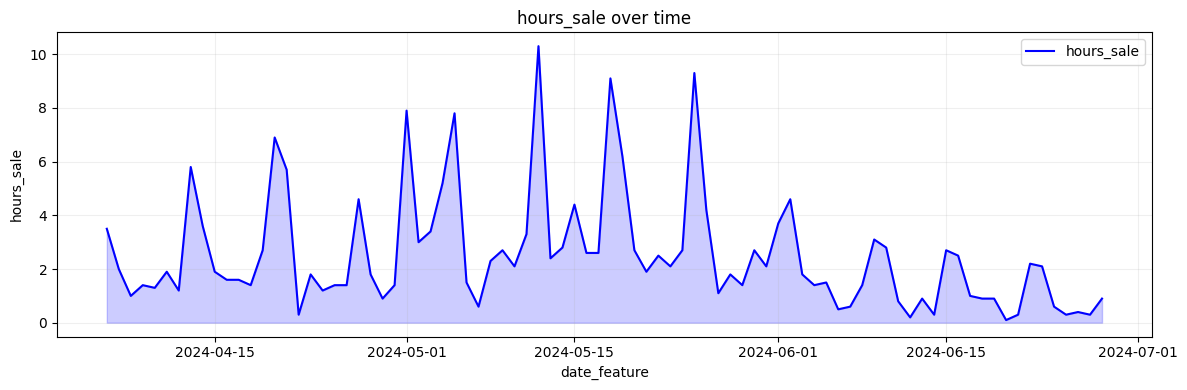

In [11]:
# Make a copy to avoid modifying the original
ts = df_daily.copy()
ts = ts.loc[(ts['store_id'] == 7) & (ts['product_id'] == 4)]  # <-- added filter
ts['date_feature'] = pd.to_datetime(ts['date_feature'])
ts = ts.sort_values('date_feature')

# Plot the line
plt.figure(figsize=(12, 4))
plt.plot(ts['date_feature'], ts['hours_sale'], label='hours_sale', color='blue')

# Add shading under the curve
plt.fill_between(ts['date_feature'], ts['hours_sale'], color='blue', alpha=0.2)

# Labels and styling
plt.title('hours_sale over time')
plt.xlabel('date_feature')
plt.ylabel('hours_sale')
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# ---- unchanged helper (your original triple logic) ----
# Replaces week/year increment with a 1-day increment on date_feature
def increment_date_feature(d):
    return d + pd.Timedelta(days=1)

def _compute_week_sat_fri(dates_like):
    # Week-of-year using Saturday-anchored weeks (Sat–Fri)
    dates = pd.to_datetime(pd.Index(dates_like))
    # .to_period('W-SAT').week yields week number under Sat-anchored calendar
    return dates.to_period('W-SAT').week.to_numpy()

def _compute_weekday_name(dates_like):
    dates = pd.to_datetime(pd.Index(dates_like))
    return dates.day_name().to_numpy()

def seasonal_factors_mul2(s, d, slen, cols):
    for i in range(slen):
        s[i] = np.mean([d[j] for j in range(i, cols, slen)])  # Season average
    s /= np.mean(s[:slen])  # Scale all season factors (sum of factors = slen)
    return s

def triple_exp_smooth_mul2(df, slen=7, extra_periods=7, alpha=.18, beta=.60, phi=.70, gamma=.10):
    """
    Multiplicative Holt-Winters with damping (phi), applied per (store_id, product_id).
    Returns concatenated results for all series, including the original columns.
    """
    df = df.copy()
    df['store_product'] = df['store_id'].astype(str) + '_' + df['product_id'].astype(str)
    df['date_feature'] = pd.to_datetime(df['date_feature'])
    df = df.sort_values(['store_product', 'date_feature'])

    customers = df['store_product'].unique()
    df_out_all = pd.DataFrame()

    for customer in customers:
        df_customer = df[df['store_product'] == customer].sort_values('date_feature')

        d_hist = df_customer['hours_sale'].values
        cols = len(d_hist)
        if cols == 0:
            continue
        d = np.append(d_hist, [np.nan]*extra_periods)

        f, a, b, s = np.full((4, cols + extra_periods), np.nan)

        eff_slen = min(slen, max(cols, 1))
        s = seasonal_factors_mul2(s, d[:-extra_periods], eff_slen, cols)

        a[0] = d[0] / s[0]
        b[0] = (d[1] / s[1] - d[0] / s[0]) if cols > 1 else 0.0

        for t in range(1, min(eff_slen, cols)):
            f[t] = (a[t-1] + phi*b[t-1]) * s[t]
            a[t] = alpha * (d[t] / s[t]) + (1 - alpha) * (a[t-1] + phi*b[t-1])
            b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]

        for t in range(eff_slen, cols):
            f[t] = (a[t-1] + phi*b[t-1]) * s[t - eff_slen]
            a[t] = alpha * (d[t] / s[t - eff_slen]) + (1 - alpha) * (a[t-1] + phi*b[t-1])
            b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]
            s[t] = gamma * (d[t] / a[t]) + (1 - gamma) * s[t - eff_slen]

        for t in range(cols, cols + extra_periods):
            f[t] = (a[t-1] + phi*b[t-1]) * s[t - eff_slen]
            a[t] = f[t] / s[t - eff_slen]
            b[t] = phi * b[t-1]
            s[t] = s[t - eff_slen]

        store_product_arr = np.append(
            df_customer['store_product'].values,
            [df_customer['store_product'].iloc[-1]] * extra_periods
        )

        last_date = df_customer['date_feature'].iloc[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                     periods=extra_periods, freq='D')
        date_feature = np.append(df_customer['date_feature'].values, future_dates)

        # ---- include original columns in output ----
        store_id_arr = np.append(df_customer['store_id'].values,
                                 [df_customer['store_id'].iloc[-1]] * extra_periods)
        product_id_arr = np.append(df_customer['product_id'].values,
                                   [df_customer['product_id'].iloc[-1]] * extra_periods)
        week_sat_fri_arr = _compute_week_sat_fri(date_feature)
        week_day_name_arr = _compute_weekday_name(date_feature)

        df_out = pd.DataFrame.from_dict({
            'store_product': store_product_arr,
            'store_id': store_id_arr,
            'product_id': product_id_arr,
            'date_feature': date_feature,
            'week_sat_fri': week_sat_fri_arr,
            'week_day_name': week_day_name_arr,
            'hours_sale': d,
            'Forecast': f,
            'Level': a,
            'Trend': b,
            'Season': s,
            'Error': d - f
        })

        df_out_all = pd.concat([df_out_all, df_out], ignore_index=True)

    return df_out_all

def Triple_exp_smooth_opti2(df, extra_periods=7, slen=7):
    df = df.copy()
    df['store_product'] = df['store_id'].astype(str) + '_' + df['product_id'].astype(str)
    df['date_feature'] = pd.to_datetime(df['date_feature'])

    df_out_all = pd.DataFrame()
    customers = df['store_product'].unique()

    for customer in customers:
        df_customer = df[df['store_product'] == customer].sort_values('date_feature')

        params, KPIs, dfs = [], [], []
        for beta in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
            for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
                for phi in [.75, .8, .9, .95]:
                    for gamma in [.2]:
                        df_out = triple_exp_smooth_mul2(
                            df_customer,
                            slen=slen,
                            extra_periods=extra_periods,
                            alpha=alpha, beta=beta, phi=phi, gamma=gamma
                        )
                        params.append(f'triple Smoothing, alpha: {alpha}, beta: {beta}, phi: {phi}, gamma: {gamma}')
                        dfs.append(df_out)
                        KPIs.append(np.sqrt((df_out['Error']**2).mean()))

        mini = np.argmin(KPIs)
        print(f'Best solution for {customer}: {params[mini]} with RMSE {round(KPIs[mini], 2)}')
        df_out_all = pd.concat([df_out_all, dfs[mini]], ignore_index=True)

    return df_out_all

def select_base_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return only these columns, in order:
    'date_feature', 'store_id', 'product_id', 'week_sat_fri', 'week_day_name', 'hours_sale'
    """
    wanted = ['date_feature', 'store_id', 'product_id', 'week_sat_fri', 'week_day_name', 'hours_sale']
    missing = [c for c in wanted if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")
    return df[wanted].dropna().copy()

def _per_series_outlier_steps_1_to_9(g: pd.DataFrame, z_score: float) -> pd.DataFrame:
    """Apply steps 1–9 to a single store_product group."""
    out = g.copy()

    # 1) MAE
    out['MAE'] = out['Error'].abs().mean()

    # 2) Absolute Error
    out['Absolute Error'] = out['Error'].abs()

    # 3) Squared Error around MAE
    out['Squared Error'] = (out['Absolute Error'] - out['MAE']) ** 2

    # 4) Standard Deviation (std implied by those squared deviations)
    out['Standard Deviation'] = np.sqrt(out['Squared Error'].mean())

    # 5) z_score column (parameterized)
    out['z_score'] = float(z_score)

    # 6) Confidence band width
    out['Confidence'] = out['MAE'] + out['z_score'] * out['Standard Deviation']

    # 7–8) Positive / Negative confidence intervals
    out['Positive Conf Interval'] = out['Forecast'] + out['Confidence']
    out['Negative Conf Interval'] = out['Forecast'] - out['Confidence']

    # 9) Clip hours_sale to the band
    out['hours_sale_no_outlier'] = np.where(
        out['hours_sale'] > out['Positive Conf Interval'], out['Positive Conf Interval'],
        np.where(
            out['hours_sale'] < out['Negative Conf Interval'], out['Negative Conf Interval'],
            out['hours_sale']
        )
    )
    return out


def outlier_remover_interpretable(df: pd.DataFrame, z_score: float = 1.96) -> pd.DataFrame:
    """
    Steps 1–9 applied per store_product; step 10 applied once after all groups.
    Returns all original columns plus all intermediate columns.
    """
    # Input checks
    needed = {'store_product', 'Error', 'Forecast', 'hours_sale'}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Missing required column(s): {sorted(missing)}")

    # Steps 1–9 per store_product
    parts = []
    for sp, g in df.groupby('store_product', sort=False):
        parts.append(_per_series_outlier_steps_1_to_9(g, z_score))
    out = pd.concat(parts, axis=0)

    # 10) outlier_ratio AFTER all iterations
    denom = out['hours_sale'].replace(0, 1)
    out['outlier_ratio'] = out['hours_sale_no_outlier'] / denom
    #out['outlier_ratio']  = out['outlier_ratio'].replace(0, 1)

    return out

def outlier_remover(df: pd.DataFrame, z_score: float = 1.96) -> pd.DataFrame:
    """
    Same computation as outlier_remover_interpretable, but returns ONLY:
      - 'hours_sale_no_outlier'
      - 'outlier_ratio'
    (index preserved for easy join back to the original df if desired)
    """
    tmp = outlier_remover_interpretable(df, z_score=z_score)
    return tmp[['store_id', 'product_id', 'week_sat_fri', 'week_day_name', 'store_product', 'hours_sale', 'date_feature', 'Forecast', 'Level', 'Trend', 'Season', 'Error','hours_sale_no_outlier', 'outlier_ratio']]
   

In [13]:
df_daily_no_outliers1 = Triple_exp_smooth_opti2(df_daily)

Best solution for 1_439: triple Smoothing, alpha: 0.6, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.88
Best solution for 1_634: triple Smoothing, alpha: 0.3, beta: 0.2, phi: 0.75, gamma: 0.2 with RMSE 0.27
Best solution for 7_4: triple Smoothing, alpha: 0.2, beta: 0.1, phi: 0.75, gamma: 0.2 with RMSE 1.51
Best solution for 15_318: triple Smoothing, alpha: 0.1, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.47
Best solution for 92_447: triple Smoothing, alpha: 0.2, beta: 0.5, phi: 0.75, gamma: 0.2 with RMSE 0.33
Best solution for 92_535: triple Smoothing, alpha: 0.2, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.23
Best solution for 312_6: triple Smoothing, alpha: 0.2, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.38
Best solution for 419_460: triple Smoothing, alpha: 0.4, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.51
Best solution for 419_834: triple Smoothing, alpha: 0.05, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 1.21
Best solution for 501_387: triple Smoothing, alpha: 0.4, beta

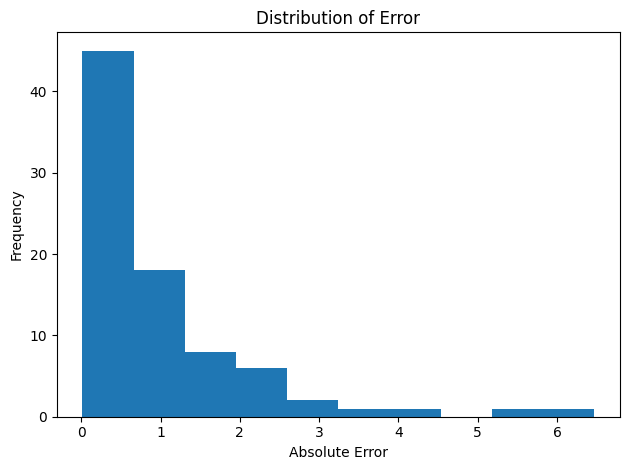

In [14]:
# Error Distribution
import matplotlib.pyplot as plt

# Filter first, then copy
hs = df_daily_no_outliers1.loc[(df_daily_no_outliers1['store_id'] == 7) & (df_daily_no_outliers1['product_id'] == 4)].copy()
hs['Absolute Error'] = hs['Error'].abs()

# Create a figure *and* axes (note the parentheses)
fig, ax = plt.subplots()

# Plot histogram of hours_sale (drop NaNs to avoid warnings)
ax.hist(hs['Absolute Error'].dropna(), bins=10)

ax.set_xlabel('Absolute Error')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Error')

plt.tight_layout()
plt.show()



<Axes: title={'center': 'Double Smoothing'}, xlabel='Period'>

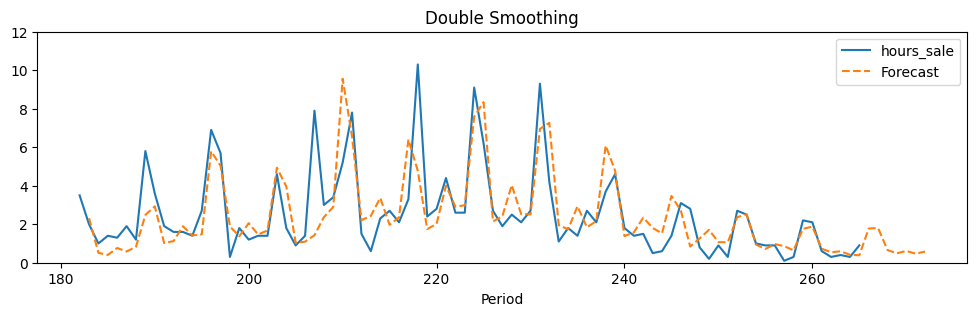

In [15]:
# Assuming 'Model_output_add_iterate' is your DataFrame and 'customer' is the selected customer
selected_store_product_data =  df_daily_no_outliers1[df_daily_no_outliers1['store_product'] == '7_4']
selected_store_product_data.index.name = 'Period'
selected_store_product_data[['hours_sale', 'Forecast']].plot(figsize=(12,3), title='Double Smoothing', ylim=(0,12), style=['-', '--'])

In [16]:
df_daily_no_outliers1 = outlier_remover(df_daily_no_outliers1, 1.96)

In [17]:
df_hourly_no_outliers = df_hourly.merge(
    df_daily_no_outliers1[['store_id', 'product_id', 'date_feature', 'outlier_ratio']],
    on=['store_id', 'product_id', 'date_feature'],
    how='left'
)
df_hourly_no_outliers['hours_sale'] = df_hourly_no_outliers['hours_sale']*df_hourly_no_outliers['outlier_ratio']
df_hourly_no_outliers = df_hourly_no_outliers.drop(columns='outlier_ratio')

In [18]:
df_daily_no_outliers1 = df_daily_no_outliers1.drop(columns='hours_sale')
df_daily_no_outliers1 = df_daily_no_outliers1.rename(columns={'hours_sale_no_outlier': 'hours_sale'})
df_daily_no_outliers1 = select_base_columns(df_daily_no_outliers1)

In [19]:
df_daily_no_outliers1 = Triple_exp_smooth_opti2(df_daily_no_outliers1)

Best solution for 1_439: triple Smoothing, alpha: 0.6, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.76
Best solution for 1_634: triple Smoothing, alpha: 0.3, beta: 0.3, phi: 0.75, gamma: 0.2 with RMSE 0.26
Best solution for 7_4: triple Smoothing, alpha: 0.2, beta: 0.3, phi: 0.75, gamma: 0.2 with RMSE 1.18
Best solution for 15_318: triple Smoothing, alpha: 0.1, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.45
Best solution for 92_447: triple Smoothing, alpha: 0.2, beta: 0.5, phi: 0.75, gamma: 0.2 with RMSE 0.33
Best solution for 92_535: triple Smoothing, alpha: 0.3, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.21
Best solution for 312_6: triple Smoothing, alpha: 0.2, beta: 0.1, phi: 0.75, gamma: 0.2 with RMSE 0.36
Best solution for 419_460: triple Smoothing, alpha: 0.5, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 0.47
Best solution for 419_834: triple Smoothing, alpha: 0.05, beta: 0.05, phi: 0.75, gamma: 0.2 with RMSE 1.18
Best solution for 501_387: triple Smoothing, alpha: 0.4, beta:

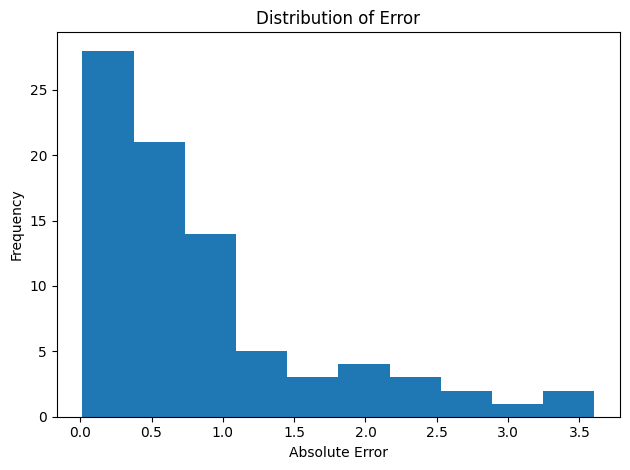

In [20]:
# Error Distribution
import matplotlib.pyplot as plt

# Filter first, then copy
hs = df_daily_no_outliers1.loc[(df_daily_no_outliers1['store_id'] == 7) & (df_daily_no_outliers1['product_id'] == 4)].copy()
hs['Absolute Error'] = hs['Error'].abs()

# Create a figure *and* axes (note the parentheses)
fig, ax = plt.subplots()

# Plot histogram of hours_sale (drop NaNs to avoid\ warnings)
ax.hist(hs['Absolute Error'].dropna(), bins=10)

ax.set_xlabel('Absolute Error')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Error')

plt.tight_layout()
plt.show()


<Axes: title={'center': 'Double Smoothing'}, xlabel='Period'>

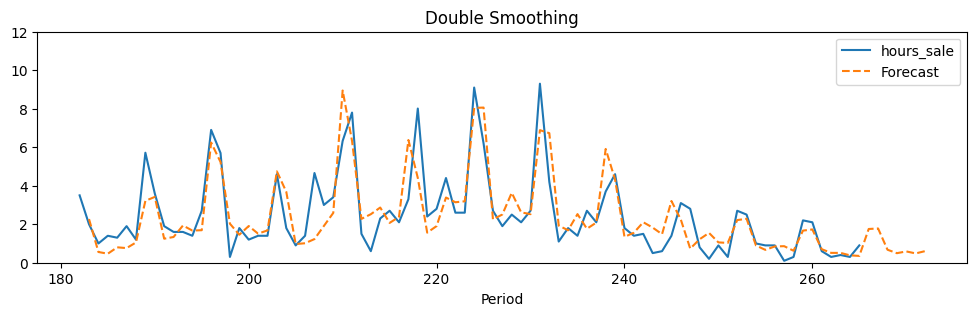

In [21]:
# Assuming 'Model_output_add_iterate' is your DataFrame and 'customer' is the selected customer
selected_store_product_data =  df_daily_no_outliers1[df_daily_no_outliers1['store_product'] == '7_4']
selected_store_product_data.index.name = 'Period'
selected_store_product_data[['hours_sale', 'Forecast']].plot(figsize=(12,3), title='Double Smoothing', ylim=(0,12), style=['-', '--'])

In [22]:
#Creates a copy of df_daily_no_outliers1 for faster iterative development
df_daily_no_outliers = df_daily_no_outliers1.copy()

In [23]:
#Creates rank feature
df_daily_no_outliers['date_rank'] = (
    df_daily_no_outliers['date_feature'].rank(method='dense', ascending=True).astype(int)
)

In [24]:

# function for moving average feature
import numpy as np
from sklearn.linear_model import LinearRegression

def add_moving_average_by_store_product(df, window=8):
    
    #For each store_product, compute a simple moving average (SMA)
    #of hours_sale ordered by date_feature.
    #Adds a new column 'SMA_<window>'.
    
    df = df.copy()
    df = df.sort_values(['store_product', 'date_feature'])

    df[f'SMA_{7}'] = (
        df.groupby('store_product')['hours_sale']
          .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )

    return df
# function for regression feature
def add_regression_by_store_product(df: pd.DataFrame) -> pd.DataFrame:
    
    #For each 'store_product', fit hours_sale ~ date_rank using only rows where both
    #are non-NaN. Write predictions for all rows to 'Regression'.
    #Fallbacks:
    #  - If <2 valid points or no x-variance: fill with group's mean hours_sale.
    #  - If no valid points: fill with NaN.
    
    df = df.copy()

    def fit_and_predict(g: pd.DataFrame) -> pd.DataFrame:
        mask = g['hours_sale'].notna() & g['date_rank'].notna()
        n_valid = int(mask.sum())
        x_unique = g.loc[mask, 'date_rank'].nunique()

        if n_valid >= 2 and x_unique >= 2:
            X_fit = g.loc[mask, ['date_rank']].to_numpy(dtype=float)
            y_fit = g.loc[mask, 'hours_sale'].to_numpy(dtype=float)
            model = LinearRegression().fit(X_fit, y_fit)
            X_all = g[['date_rank']].to_numpy(dtype=float)
            g.loc[:, 'Regression'] = model.predict(X_all)
        elif n_valid >= 1:
            mean_y = float(g.loc[mask, 'hours_sale'].mean())
            g.loc[:, 'Regression'] = mean_y
        else:
            g.loc[:, 'Regression'] = np.nan

        return g

    return df.groupby('store_product', group_keys=False).apply(fit_and_predict)


In [25]:
df_daily_no_outliers = add_moving_average_by_store_product(df_daily_no_outliers)

In [26]:
df_daily_no_outliers = add_regression_by_store_product(df_daily_no_outliers)

/var/tmp/ipykernel_11846/3030386668.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('store_product', group_keys=False).apply(fit_and_predict)


In [27]:
#df_daily_no_outliers = df_daily_no_outliers.dropna()

In [28]:
df_daily_no_outliers.loc[(df_daily_no_outliers['store_id'] == 7) & (df_daily_no_outliers['product_id'] == 4)].tail(8)

,store_product,store_id,product_id,date_feature,week_sat_fri,week_day_name,hours_sale,Forecast,Level,Trend,Season,Error,date_rank,SMA_7,Regression
265,7_4,7,4,2024-06-28,26,Friday,0.9,0.353710,0.903624,0.033060,0.609075,0.54629,84,0.887500,1.599424
266,7_4,7,4,2024-06-29,26,Saturday,NaN,1.752785,0.928418,0.024795,1.887925,NaN,85,0.971429,1.578495
267,7_4,7,4,2024-06-30,27,Sunday,NaN,1.778121,0.947015,0.018596,1.877607,NaN,86,0.766667,1.557567
268,7_4,7,4,2024-07-01,27,Monday,NaN,0.675116,0.960962,0.013947,0.702542,NaN,87,0.500000,1.536638
269,7_4,7,4,2024-07-02,27,Tuesday,NaN,0.495672,0.971422,0.010460,0.510253,NaN,88,0.475000,1.515710
270,7_4,7,4,2024-07-03,27,Wednesday,NaN,0.587427,0.979268,0.007845,0.599863,NaN,89,0.533333,1.494781
271,7_4,7,4,2024-07-04,27,Thursday,NaN,0.482967,0.985152,0.005884,0.490246,NaN,90,0.600000,1.473852
272,7_4,7,4,2024-07-05,27,Friday,NaN,0.602719,0.989565,0.004413,0.609075,NaN,91,0.900000,1.452924


In [29]:

#Creates Average Seasonality
avg_by_prod_wd = (
    df_daily_no_outliers
    .groupby(['store_product', 'week_day_name'], as_index=False)['hours_sale']
    .mean()
    .rename(columns={'hours_sale': 'Average Seasonality'})
)
df_daily_no_outliers = df_daily_no_outliers.merge(
    avg_by_prod_wd, on=['store_product', 'week_day_name'], how='left'
)
#Creates 7 day lagged copy of original data set
df_daily_no_outliers2 = df_daily_no_outliers.copy()

s = df_daily_no_outliers2['date_feature']
if not pd.api.types.is_datetime64_any_dtype(s):
    s = pd.to_datetime(s, errors='coerce')
df_daily_no_outliers2['date_feature'] = s - pd.Timedelta(days=7)

#Error with 7 day lag was removed due to it having nan values
df_daily_no_outliers2 = df_daily_no_outliers2[['store_product', 'date_feature', 'Forecast', 'Level', 'Trend', 'Season', 'Regression', 'SMA_7']]
df_daily_no_outliers2 = df_daily_no_outliers2.rename(columns={'Forecast': 'Forecast_7day_lag', 'Level': 'Level_7day_lag', 'Trend': 'Trend_7day_lag',
                                                              'Season': 'Season_7day_lag',  'Regression': 'Regression_7day_lag', 'SMA_7': 'SMA_7_7day_lag'})

#Joins lagged variables from lagged data set onto the original data set
df_daily_no_outliers = df_daily_no_outliers.merge(
    df_daily_no_outliers2, on=['store_product', 'date_feature'], how='left'
)

#Creates a Weekend Classifier column
weekend_days = {'Saturday', 'Sunday'}
df_daily_no_outliers['Weekend Classifier'] = df_daily_no_outliers['week_day_name'].apply(
    lambda x: 'Weekend' if x in weekend_days else 'Weekday'
)
#Removes all rows where 'hours_sale' is NaN
df_daily_no_outliers = df_daily_no_outliers.dropna()

In [30]:
df_daily_no_outliers.columns

Index(['store_product', 'store_id', 'product_id', 'date_feature',
       'week_sat_fri', 'week_day_name', 'hours_sale', 'Forecast', 'Level',
       'Trend', 'Season', 'Error', 'date_rank', 'SMA_7', 'Regression',
       'Average Seasonality', 'Forecast_7day_lag', 'Level_7day_lag',
       'Trend_7day_lag', 'Season_7day_lag', 'Regression_7day_lag',
       'SMA_7_7day_lag', 'Weekend Classifier'],
      dtype='object')

In [34]:
#data set filtered by store id and product id
#ts = df_daily_no_outliers.loc[(df_daily_no_outliers['store_id'] == 7) & (df_daily_no_outliers['product_id'] == 4)]
#data set filtered by store id and product id
ts = df_daily_no_outliers.copy()

In [35]:
def import_data(input_data):
    input_data = input_data[['store_id', 'product_id', 'date_feature', 'week_sat_fri', 'hours_sale']]
    # Combine Year + Quarter into a single period label: 2021_01, 2021_02, etc.
    input_data['Period'] = (
        input_data['week_sat_fri'].astype(str) + '_' + 
        input_data['date_feature'].astype(str).str.zfill(2)
    )
    # Pivot "Historical Demand" so columns = each period in time
    df_pivot = pd.pivot_table(
        data     = input_data,
        values   = 'hours_sale',
        index    = ['store_id', 'product_id'],
        columns  = 'Period',
        aggfunc  = 'sum',
        fill_value=0
    )
    return df_pivot
df = import_data(ts)

/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


In [36]:
df.head()

Period               15_2024-04-07  15_2024-04-08  15_2024-04-09  \
store_id product_id                                                
1        439                   0.4       0.300000       0.400000   
         634                   0.1       0.472493       0.400000   
7        4                     2.0       1.000000       1.400000   
15       318                   1.2       0.000001       0.200000   
92       447                   1.0       0.700000       0.890722   

Period               15_2024-04-10  15_2024-04-11  15_2024-04-12  \
store_id product_id                                                
1        439              0.300000       0.500000       0.400000   
         634              0.537397       0.680899       0.700000   
7        4                1.300000       1.900000       1.200000   
15       318              1.100000       0.000001       0.000001   
92       447              0.000001       0.749920       0.600000   

Period               15_2024-04-13  16_2024-04-14  16_2024-04-15  \
store_id product_id                                                
1        439              0.200000            0.5       0.900000   
         634              0.900000            0.7       1.000000   
7        4                5.713513            3.6       1.900000   
15       318              0.500000            1.5       0.000001   
92       447              0.000001            0.9       0.500000   

Period               16_2024-04-16  ...  25_2024-06-19  25_2024-06-20  \
store_id product_id                 ...                                 
1        439                  0.10  ...            0.2       0.700000   
         634                  0.60  ...            0.7       0.881186   
7        4                    1.60  ...            0.9       0.100000   
15       318                  0.90  ...            0.8       1.000000   
92       447                  0.85  ...            0.6       0.500000   

Period               25_2024-06-21  25_2024-06-22  26_2024-06-23  \
store_id product_id                                                
1        439                   1.2            2.1            1.1   
         634                   0.7            0.9            1.0   
7        4                     0.3            2.2            2.1   
15       318                   0.8            1.4            1.8   
92       447                   1.0            0.3            1.1   

Period               26_2024-06-24  26_2024-06-25  26_2024-06-26  \
store_id product_id                                                
1        439                   1.3            0.7            1.1   
         634                   0.7            0.9            0.5   
7        4                     0.6            0.3            0.4   
15       318                   0.8            1.5            0.7   
92       447                   1.0            0.2            0.5   

Period               26_2024-06-27  26_2024-06-28  
store_id product_id                                
1        439                   1.5           1.00  
         634                   0.7           0.88  
7        4                     0.3           0.90  
15       318                   1.1           1.00  
92       447                   0.4           0.90  

[5 rows x 83 columns]

In [37]:
# Code 3 (revised): function to build X_exo for a single store_id/product_id subset

import numpy as np
import pandas as pd

def build_exo_features(ts_subset):
    """
    ts_subset: long daily table filtered to a single (store_id, product_id),
               with all the columns you listed (week_sat_fri, Forecast, Level, Trend, etc.)
    Returns:
        X_exo_combined: np.array of shape (time_periods, n_exo_features)
        feature_names_exo: list of feature names
    """
    df_idx = ts_subset.copy()
    df_idx['date_feature'] = pd.to_datetime(df_idx['date_feature'], errors='coerce')
    df_idx = df_idx.dropna(subset=['date_feature'])

    # --- One-hot weekday (fixed, stable order) ---
    ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    df_idx['week_day_name'] = pd.Categorical(df_idx['week_day_name'],
                                             categories=ordered_days, ordered=True)
    dow_ohe = pd.get_dummies(df_idx['week_day_name'], prefix='_', dtype=int)
    dow_cols = [f'_{d}' for d in ordered_days]
    for c in dow_cols:
        if c not in dow_ohe.columns:
            dow_ohe[c] = 0
    dow_ohe = dow_ohe[dow_cols]

    # --- One-hot Weekend Classifier (fixed order) ---
    wec_order = ['Weekday', 'Weekend']
    if 'Weekend Classifier' in df_idx.columns:
        df_idx['Weekend Classifier'] = pd.Categorical(
            df_idx['Weekend Classifier'],
            categories=wec_order,
            ordered=True
        )
        wec_ohe = pd.get_dummies(df_idx['Weekend Classifier'], prefix='wec', dtype=int)
    else:
        wec_ohe = pd.DataFrame(index=df_idx.index)

    wec_cols = [f'wec_{c}' for c in wec_order]
    for c in wec_cols:
        if c not in wec_ohe.columns:
            wec_ohe[c] = 0
    wec_ohe = wec_ohe[wec_cols]

    # --- Numeric / continuous features ---
    numeric_cols = [
        'week_sat_fri', 'Forecast', 'Level', 'Trend', 'Season',
        'Error', 'date_rank', 'SMA_7', 'Regression', 'Average Seasonality',
        'Forecast_7day_lag', 'Level_7day_lag', 'Trend_7day_lag',
        'Season_7day_lag', 'Regression_7day_lag', 'SMA_7_7day_lag'
    ]

    base = pd.DataFrame(index=df_idx.index)
    for c in numeric_cols:
        base[c] = df_idx[c] if c in df_idx.columns else 0.0  # safe default if missing

    # Final column order: numeric, then weekday dummies, then weekend classifier dummies
    final_cols = numeric_cols + dow_cols + wec_cols
    aligned = pd.concat([base, dow_ohe, wec_ohe], axis=1)
    for c in final_cols:
        if c not in aligned.columns:
            aligned[c] = 0

    X_exo = aligned[final_cols].to_numpy(dtype=float)
    feature_names_exo = final_cols

    return X_exo, feature_names_exo


In [38]:
# Code 4 (unchanged logic): builds X_train, Y_train, X_test, Y_test from a pivoted df and X_exo

def datasets_exo(df, X_exo, x_len=21, y_len=14, test_loops=1):
    """
    df:     pivoted DataFrame of shape (rows, time_periods)
    X_exo:  array of shape (time_periods, n_exo_features).
            e.g., columns = [Week number, AMT Topline, Holiday Classifier].
    """
    # Convert pivot to raw matrix of shape (rows, time_periods)
    D = df.values
    rows, periods = D.shape
    
    # Expand X_exo to (rows, periods, n_exo_features)
    n_exo = X_exo.shape[1]
    X_exo_3d = np.repeat(X_exo[np.newaxis, :, :], repeats=rows, axis=0)
    # shape: (rows, periods, n_exo_features)

    # How many sliding windows can we form?
    loops = periods + 1 - x_len - y_len  # same as (periods - x_len - y_len + 1)

    all_windows = []
    for col in range(loops):
        # Exogenous block for [col .. col+x_len-1]
        exo_block = X_exo_3d[:, col: col + x_len, :]          # (rows, x_len, n_exo_features)
        exo_block_flat = exo_block.reshape(rows, x_len * n_exo)

        # Demand block includes x_len + y_len columns
        demand_block = D[:, col: col + x_len + y_len]         # (rows, x_len + y_len)

        # Combine exo + demand
        combined = np.hstack([exo_block_flat, demand_block])  # (rows, x_len*n_exo + x_len + y_len)
        all_windows.append(combined)

    # Stack all windows vertically: (rows*loops, some_width)
    train = np.vstack(all_windows)

    # Split off the last y_len columns as target
    X_train, Y_train = np.split(train, [-y_len], axis=1)

    # -------------------------------------------------
    # Create TEST SET from the final test_loops windows
    # -------------------------------------------------
    if test_loops > 0:
        test_size = rows * test_loops
        X_train, X_test = np.split(X_train, [-test_size], axis=0)
        Y_train, Y_test = np.split(Y_train, [-test_size], axis=0)
    else:
        # Fallback if no test set
        X_test = np.hstack([exo_block_flat, D[:, -x_len:]])
        Y_test = np.full((rows, y_len), np.nan)
    
    return X_train, Y_train, X_test, Y_test


In [39]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name
    df.loc['Train', 'MAE']  = 100*np.mean(abs(Y_train - Y_train_pred))/np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100*np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100*np.mean((Y_train - Y_train_pred))/np.mean(Y_train)
    df.loc['Test',  'MAE']  = 100*np.mean(abs(Y_test - Y_test_pred))/np.mean(Y_test)
    df.loc['Test',  'RMSE'] = 100*np.sqrt(np.mean((Y_test - Y_test_pred)**2))/np.mean(Y_test)
    df.loc['Test',  'Bias'] = 100*np.mean((Y_test - Y_test_pred))/np.mean(Y_test)
    df = df.astype(float).round(1)  # Round number for display
    print(df)
    return df

In [41]:
#Neural network model for training
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import numpy as np
import pandas as pd

# ----- Containers to collect NN results across all (store_id, product_id) -----
nn_param_records = []       # best params per combo
nn_metrics_records = []     # KPI tables for each combo
nn_X_train_list = []
nn_Y_train_list = []
nn_X_test_list = []
nn_Y_test_list = []
nn_Y_train_pred_list = []
nn_Y_test_pred_list = []

# ----- Sliding-window parameters (same as tree model) -----
x_len = 21
y_len = 14
test_loops = 1

# Get unique (store_id, product_id) combinations from ts
combos = (
    ts[['store_id', 'product_id']]
    .drop_duplicates()
    .sort_values(['store_id', 'product_id'])
    .to_numpy()
)

# Training parameters: candidate values (for random/search)
# =========================================
for criterion in ['squared_error']:
    global_start_time = time.time()

    # Hidden layers: lists like (n,)*L for different neuron counts n and layer counts L
    hidden_layer_sizes = [
        (neuron,) * hidden_layers
        for neuron in range(10, 61, 10)   # 10, 20, 30, 40, 50, 60
        for hidden_layers in range(2, 7)  # 2, 3, 4, 5, 6 layers
    ]

    # Regularization strength (alpha), initial learning rate, and Adam betas
    alpha = [5.0, 1.0, 0.5, 0.1, 0.05, 0.01]
    learning_rate_init = [0.05, 0.01, 0.005, 0.001, 0.0005]
    beta_1 = [0.85, 0.875, 0.9, 0.95, 0.99]
    beta_2 = [0.99, 0.995, 0.9975, 0.999, 0.9995, 0.9999]

    param_dist = {
        'hidden_layer_sizes': hidden_layer_sizes,
        'alpha': alpha,
        'learning_rate_init': learning_rate_init,
        'beta_1': beta_1,
        'beta_2': beta_2,
    }

    # =========================================
    # Early stopping: fixed parameters (same as your original)
    # =========================================
    activation = 'relu'
    solver = 'adam'
    early_stopping = True
    n_iter_no_change = 200
    validation_fraction = 0.1
    tol = 1e-4  # 0.0001

    param_fixed = {
        'activation': activation,
        'solver': solver,
        'early_stopping': early_stopping,
        'n_iter_no_change': n_iter_no_change,
        'validation_fraction': validation_fraction,
        'tol': tol,
    }

    # Base estimator uses your fixed early-stopping params
    NN_base = MLPRegressor(**param_fixed)

    # Loop through each (store_id, product_id) combo independently
    for store_id_val, product_id_val in combos:

        # --- Filter to one combination only ---
        ts_sp = ts[
            (ts['store_id'] == store_id_val) &
            (ts['product_id'] == product_id_val)
        ].copy()

        # Sort by date and ensure enough rows
        ts_sp = ts_sp.sort_values('date_feature')
        if ts_sp.shape[0] < (x_len + y_len + 1):
            continue

        # --- Pivot to wide format for this combo (Code 2 logic) ---
        df_sp = import_data(ts_sp)  # single row, many periods

        if df_sp.shape[1] < (x_len + y_len + 1):
            continue

        # --- Build exogenous features for this combo (revised Code 3) ---
        X_exo_sp, feature_names_exo = build_exo_features(ts_sp)

        # Align lengths between df_sp (periods) and X_exo_sp (time steps)
        periods = df_sp.shape[1]
        if X_exo_sp.shape[0] > periods:
            X_exo_sp = X_exo_sp[:periods, :]
        elif X_exo_sp.shape[0] < periods:
            df_sp = df_sp.iloc[:, :X_exo_sp.shape[0]]
            periods = df_sp.shape[1]

        # --- Build datasets for this combo (Code 4) ---
        X_train, Y_train, X_test, Y_test = datasets_exo(
            df     = df_sp,
            X_exo  = X_exo_sp,
            x_len  = x_len,
            y_len  = y_len,
            test_loops = test_loops
        )

        # --- Optimization (k-fold CV + random search) ---
        NN_cv = RandomizedSearchCV(
            NN_base,
            param_dist,
            cv=4,
            verbose=1,
            n_jobs=-1,
            n_iter=500,
            scoring='neg_mean_absolute_error'
        )

        start_time = time.time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=ConvergenceWarning,
                module=r"sklearn\.neural_network"
            )
            NN_cv.fit(X_train, Y_train)

        print(f"[NN] Combo store_id={store_id_val}, product_id={product_id_val}")
        print("Tuned NN Parameters:", NN_cv.best_params_)

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=ConvergenceWarning,
                module=r"sklearn\.neural_network"
            )
            Y_train_pred = NN_cv.predict(X_train)
            Y_test_pred  = NN_cv.predict(X_test)

        # KPIs for this combo
        kpi_name = f'Neural Network – optimized {criterion} (s{store_id_val}, p{product_id_val})'
        kpi_df = kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=kpi_name)
        kpi_df = kpi_df.reset_index().rename(columns={'index': 'Set'})
        kpi_df['store_id'] = store_id_val
        kpi_df['product_id'] = product_id_val
        nn_metrics_records.append(kpi_df)

        # Save best parameters for this combo
        nn_param_records.append({
            'store_id': store_id_val,
            'product_id': product_id_val,
            **NN_cv.best_params_
        })

        # Save all X/Y splits and predictions with identifiers
        nn_X_train_list.append(
            pd.DataFrame(X_train).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='train'
            )
        )
        nn_Y_train_list.append(
            pd.DataFrame(Y_train).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='train'
            )
        )
        nn_Y_train_pred_list.append(
            pd.DataFrame(Y_train_pred).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='train'
            )
        )

        nn_X_test_list.append(
            pd.DataFrame(X_test).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='test'
            )
        )
        nn_Y_test_list.append(
            pd.DataFrame(Y_test).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='test'
            )
        )
        nn_Y_test_pred_list.append(
            pd.DataFrame(Y_test_pred).assign(
                store_id=store_id_val,
                product_id=product_id_val,
                set='test'
            )
        )

        print('{:0.2f} seconds for this combo'.format(time.time() - start_time))

    print('Total NN run time for criterion {}: {:0.2f} seconds'.format(
        criterion, time.time() - global_start_time
    ))

# ---------- Final concatenated NN outputs ----------

nn_params_df       = pd.DataFrame(nn_param_records)
nn_metrics_df_all  = pd.concat(nn_metrics_records, ignore_index=True) if nn_metrics_records else pd.DataFrame()

nn_X_train_all      = pd.concat(nn_X_train_list,      ignore_index=True) if nn_X_train_list else pd.DataFrame()
nn_Y_train_all      = pd.concat(nn_Y_train_list,      ignore_index=True) if nn_Y_train_list else pd.DataFrame()
nn_X_test_all       = pd.concat(nn_X_test_list,       ignore_index=True) if nn_X_test_list else pd.DataFrame()
nn_Y_test_all       = pd.concat(nn_Y_test_list,       ignore_index=True) if nn_Y_test_list else pd.DataFrame()
nn_Y_train_pred_all = pd.concat(nn_Y_train_pred_list, ignore_index=True) if nn_Y_train_pred_list else pd.DataFrame()
nn_Y_test_pred_all  = pd.concat(nn_Y_test_pred_list,  ignore_index=True) if nn_Y_test_pred_list else pd.DataFrame()

print("nn_params_df shape:", nn_params_df.shape)
print("nn_metrics_df_all shape:", nn_metrics_df_all.shape)
print("nn_X_train_all shape:", nn_X_train_all.shape)
print("nn_Y_train_all shape:", nn_Y_train_all.shape)
print("nn_X_test_all shape:", nn_X_test_all.shape)
print("nn_Y_test_all shape:", nn_Y_test_all.shape)
print("nn_Y_train_pred_all shape:", nn_Y_train_pred_all.shape)
print("nn_Y_test_pred_all shape:", nn_Y_test_pred_all.shape)

/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


Fitting 4 folds for each of 500 candidates, totalling 2000 fits
[NN] Combo store_id=1, product_id=439
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (50, 50, 50, 50), 'beta_2': 0.9999, 'beta_1': 0.875, 'alpha': 5.0}
                                                     MAE   RMSE  Bias
Neural Network – optimized squared_error (s1, p...                   
Train                                               79.4  133.2  40.6
Test                                                56.2   67.7  36.2
317.06 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=1, product_id=634
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (30, 30), 'beta_2': 0.9999, 'beta_1': 0.875, 'alpha': 0.5}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s1, p...                  
Train                                               28.6  35.8   0.4
Test                                                29.8  34.2  11.7
314.06 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=7, product_id=4
Tuned NN Parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (20, 20, 20, 20, 20, 20), 'beta_2': 0.995, 'beta_1': 0.85, 'alpha': 0.05}
                                                    MAE  RMSE  Bias
Neural Network – optimized squared_error (s7, p4)                  
Train                                              26.8  37.6   3.7
Test                                               30.1  37.2 -21.8
298.46 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=15, product_id=318
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (10, 10), 'beta_2': 0.99, 'beta_1': 0.9, 'alpha': 0.05}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s15, ...                  
Train                                               39.9  50.6  -0.2
Test                                                26.1  34.7  18.5
303.26 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=92, product_id=447
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (20, 20, 20, 20, 20), 'beta_2': 0.99, 'beta_1': 0.9, 'alpha': 5.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s92, ...                  
Train                                               40.4  48.7   0.7
Test                                                37.3  43.3   7.5
298.61 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=92, product_id=535
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (20, 20, 20, 20), 'beta_2': 0.999, 'beta_1': 0.85, 'alpha': 0.05}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s92, ...                  
Train                                               23.8  29.4   0.6
Test                                                34.6  41.1  -5.5
294.61 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=312, product_id=6
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (40, 40, 40, 40, 40, 40), 'beta_2': 0.99, 'beta_1': 0.85, 'alpha': 0.5}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s312,...                  
Train                                               29.3  36.0   3.0
Test                                                27.0  33.3  21.9
298.53 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=419, product_id=460
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (20, 20), 'beta_2': 0.9995, 'beta_1': 0.9, 'alpha': 0.5}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s419,...                  
Train                                               43.6  52.8   0.6
Test                                                51.1  61.5  -0.9
300.52 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=419, product_id=834
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (10, 10), 'beta_2': 0.995, 'beta_1': 0.85, 'alpha': 0.5}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s419,...                  
Train                                               38.9  49.9  -4.9
Test                                                42.7  54.6   1.7
289.03 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=501, product_id=387
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (40, 40, 40, 40), 'beta_2': 0.999, 'beta_1': 0.875, 'alpha': 0.1}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s501,...                  
Train                                               41.3  51.0   4.9
Test                                                40.4  48.5  14.7
287.84 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=501, product_id=705
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (30, 30, 30, 30, 30, 30), 'beta_2': 0.9975, 'beta_1': 0.875, 'alpha': 0.05}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s501,...                  
Train                                               35.8  47.1   4.1
Test                                                42.6  48.1 -19.0
292.80 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=654, product_id=19
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (10, 10, 10), 'beta_2': 0.9999, 'beta_1': 0.875, 'alpha': 5.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s654,...                  
Train                                               22.5  29.8   3.0
Test                                                34.6  39.3  22.7
294.91 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=654, product_id=259
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (60, 60, 60, 60, 60), 'beta_2': 0.99, 'beta_1': 0.9, 'alpha': 5.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s654,...                  
Train                                               36.3  44.9   6.8
Test                                                45.1  51.5  -1.1
294.62 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=777, product_id=332
Tuned NN Parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (60, 60, 60), 'beta_2': 0.99, 'beta_1': 0.875, 'alpha': 0.05}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s777,...                  
Train                                               22.1  28.2  -1.4
Test                                                18.7  22.6   5.4
297.70 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=777, product_id=731
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (20, 20, 20, 20, 20, 20), 'beta_2': 0.99, 'beta_1': 0.9, 'alpha': 1.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s777,...                  
Train                                               35.0  46.2   7.3
Test                                                52.4  67.6  -6.6
294.90 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=780, product_id=58
Tuned NN Parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (50, 50, 50, 50, 50), 'beta_2': 0.99, 'beta_1': 0.99, 'alpha': 5.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s780,...                  
Train                                               35.9  43.9   1.1
Test                                                32.5  41.3 -10.2
292.62 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=780, product_id=63
Tuned NN Parameters: {'learning_rate_init': 0.05, 'hidden_layer_sizes': (10, 10, 10, 10, 10), 'beta_2': 0.9975, 'beta_1': 0.85, 'alpha': 0.05}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s780,...                  
Train                                               75.1  93.3  17.0
Test                                                47.9  71.1  28.1
290.20 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=780, product_id=672
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10, 10), 'beta_2': 0.9995, 'beta_1': 0.875, 'alpha': 0.5}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s780,...                  
Train                                               30.1  40.3  -0.8
Test                                                42.2  49.8   2.6
289.19 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=780, product_id=839
Tuned NN Parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (10, 10, 10), 'beta_2': 0.9999, 'beta_1': 0.85, 'alpha': 5.0}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s780,...                  
Train                                               38.7  47.8   1.6
Test                                                36.3  44.8   6.0
289.77 seconds for this combo
Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/var/tmp/ipykernel_11846/556918847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Period'] = (


[NN] Combo store_id=897, product_id=287
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (10, 10), 'beta_2': 0.999, 'beta_1': 0.875, 'alpha': 0.01}
                                                     MAE  RMSE  Bias
Neural Network – optimized squared_error (s897,...                  
Train                                               67.0  79.9   0.5
Test                                                41.8  50.8  23.7
296.07 seconds for this combo
Total NN run time for criterion squared_error: 5935.40 seconds
nn_params_df shape: (20, 7)
nn_metrics_df_all shape: (40, 25)
nn_X_train_all shape: (960, 549)
nn_Y_train_all shape: (960, 17)
nn_X_test_all shape: (20, 549)
nn_Y_test_all shape: (20, 17)
nn_Y_train_pred_all shape: (960, 17)
nn_Y_test_pred_all shape: (20, 17)


In [52]:
nn_Y_test_all.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,store_id,product_id,set
0,0.7,0.5,0.5,0.7,0.2,0.700000,1.2,2.1,1.1,1.3,0.7,1.1,1.5,1.00,1,439,test
1,0.7,0.7,0.4,0.5,0.7,0.881186,0.7,0.9,1.0,0.7,0.9,0.5,0.7,0.88,1,634,test
2,2.7,2.5,1.0,0.9,0.9,0.100000,0.3,2.2,2.1,0.6,0.3,0.4,0.3,0.90,7,4,test
3,1.2,1.0,0.8,1.1,0.8,1.000000,0.8,1.4,1.8,0.8,1.5,0.7,1.1,1.00,15,318,test
4,1.0,0.8,0.7,0.7,0.6,0.500000,1.0,0.3,1.1,1.0,0.2,0.5,0.4,0.90,92,447,test


In [53]:
nn_Y_test_pred_all.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,store_id,product_id,set
0,1.083207,0.852158,0.402910,0.852062,0.645498,0.510728,0.675437,0.630077,0.554802,0.511609,0.424148,0.474408,0.450879,0.419721,1,439,test
1,0.631841,0.897847,0.653508,0.673321,0.468574,0.392512,0.531501,0.868337,0.778729,0.638715,0.481349,0.795317,0.508611,0.656444,1,634,test
2,2.890761,2.847778,1.885310,0.992748,0.757007,0.682258,0.770229,2.079291,1.954257,1.202411,0.279783,0.856647,0.614062,0.693846,7,4,test
3,0.839726,0.832453,0.871297,0.828529,0.866926,0.875748,0.846832,0.866864,0.866434,0.933873,0.884223,0.952827,0.898997,0.861210,15,318,test
4,0.581474,0.640146,0.667622,0.633560,0.567040,0.623010,0.648126,0.656094,0.641236,0.612388,0.675855,0.681662,0.711707,0.634636,92,447,test


In [62]:
#Neural network model for Inference Metrics Assessment
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

criterion = 'squared_error'

# Optional: containers if you want to store final KPIs / preds separately
nn_final_metrics_records = []
nn_final_Y_train_pred_list = []
nn_final_Y_test_pred_list = []

for store_id_val, product_id_val in combos:
    # ---- 1) Get best params for this combo from nn_params_df ----
    row = nn_params_df[
        (nn_params_df['store_id'] == store_id_val) &
        (nn_params_df['product_id'] == product_id_val)
    ]
    if row.empty:
        # This combo may have been skipped earlier (not enough data)
        continue

    best_params = row.iloc[0].drop(labels=['store_id', 'product_id']).to_dict()

    # ---- 2) Extract X_train, Y_train, X_test, Y_test for this combo ----
    train_mask_X = (
        (nn_X_train_all['store_id'] == store_id_val) &
        (nn_X_train_all['product_id'] == product_id_val) &
        (nn_X_train_all['set'] == 'train')
    )
    train_mask_Y = (
        (nn_Y_train_all['store_id'] == store_id_val) &
        (nn_Y_train_all['product_id'] == product_id_val) &
        (nn_Y_train_all['set'] == 'train')
    )
    test_mask_X = (
        (nn_X_test_all['store_id'] == store_id_val) &
        (nn_X_test_all['product_id'] == product_id_val) &
        (nn_X_test_all['set'] == 'test')
    )
    test_mask_Y = (
        (nn_Y_test_all['store_id'] == store_id_val) &
        (nn_Y_test_all['product_id'] == product_id_val) &
        (nn_Y_test_all['set'] == 'test')
    )

    X_train = nn_X_train_all.loc[train_mask_X].drop(columns=['store_id', 'product_id', 'set']).to_numpy()
    Y_train = nn_Y_train_all.loc[train_mask_Y].drop(columns=['store_id', 'product_id', 'set']).to_numpy()
    X_test  = nn_X_test_all.loc[test_mask_X].drop(columns=['store_id', 'product_id', 'set']).to_numpy()
    Y_test  = nn_Y_test_all.loc[test_mask_Y].drop(columns=['store_id', 'product_id', 'set']).to_numpy()

    # Skip if for some reason this combo has no train/test rows
    if X_train.size == 0 or X_test.size == 0:
        continue

    # ---- 3) Build the final model for this combo using best_params ----
    NN = MLPRegressor(
        n_iter_no_change=1000,
        early_stopping=True,         # so n_iter_no_change takes effect
        activation='relu',           # same fixed choices as before
        solver='adam',
        validation_fraction=0.1,
        tol=1e-4,
        **best_params                # hidden_layer_sizes, alpha, learning_rate_init, beta_1, beta_2
    )

    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=ConvergenceWarning,
            module=r"sklearn\.neural_network"
        )
        NN.fit(X_train, Y_train)

        Y_train_pred = NN.predict(X_train)
        Y_test_pred  = NN.predict(X_test)

    # ---- 4) KPIs for this combo ----
    kpi_name = f'Neural Network {criterion} (s{store_id_val}, p{product_id_val})'
    kpi_df = kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=kpi_name)
    kpi_df = kpi_df.reset_index().rename(columns={'index': 'Set'})
    kpi_df['store_id'] = store_id_val
    kpi_df['product_id'] = product_id_val
    nn_final_metrics_records.append(kpi_df)

    # (optional) store final preds in stacked form as well
    nn_final_Y_train_pred_list.append(
        pd.DataFrame(Y_train_pred).assign(
            store_id=store_id_val,
            product_id=product_id_val,
            set='train'
        )
    )
    nn_final_Y_test_pred_list.append(
        pd.DataFrame(Y_test_pred).assign(
            store_id=store_id_val,
            product_id=product_id_val,
            set='test'
        )
    )

# ---- Final concatenated KPIs and predictions for the “final models” ----
nn_final_metrics_df = (
    pd.concat(nn_final_metrics_records, ignore_index=True)
    if nn_final_metrics_records else pd.DataFrame()
)

nn_final_Y_train_pred_all = (
    pd.concat(nn_final_Y_train_pred_list, ignore_index=True)
    if nn_final_Y_train_pred_list else pd.DataFrame()
)

nn_final_Y_test_pred_all = (
    pd.concat(nn_final_Y_test_pred_list, ignore_index=True)
    if nn_final_Y_test_pred_list else pd.DataFrame()
)

print("nn_final_metrics_df shape:", nn_final_metrics_df.shape)
print("nn_final_Y_train_pred_all shape:", nn_final_Y_train_pred_all.shape)
print("nn_final_Y_test_pred_all shape:", nn_final_Y_test_pred_all.shape)


                                          MAE  RMSE  Bias
Neural Network squared_error (s1, p439)                  
Train                                    57.3  78.4   1.0
Test                                     54.0  70.3  49.2
                                          MAE  RMSE  Bias
Neural Network squared_error (s1, p634)                  
Train                                    31.6  38.8   0.9
Test                                     23.8  27.2  15.6
                                        MAE  RMSE  Bias
Neural Network squared_error (s7, p4)                  
Train                                  23.8  34.5  -0.3
Test                                   17.3  24.9  -2.6
                                           MAE  RMSE  Bias
Neural Network squared_error (s15, p318)                  
Train                                     39.8  50.6   1.3
Test                                      25.6  35.1  19.7
                                           MAE  RMSE  Bias
Neural Network sq

In [67]:
nn_Y_test_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,store_id,product_id,set
0,0.7,0.5,0.5,0.7,0.2,0.700000,1.2,2.1,1.1,1.3,0.7,1.1,1.5,1.00,1,439,test
1,0.7,0.7,0.4,0.5,0.7,0.881186,0.7,0.9,1.0,0.7,0.9,0.5,0.7,0.88,1,634,test
2,2.7,2.5,1.0,0.9,0.9,0.100000,0.3,2.2,2.1,0.6,0.3,0.4,0.3,0.90,7,4,test
3,1.2,1.0,0.8,1.1,0.8,1.000000,0.8,1.4,1.8,0.8,1.5,0.7,1.1,1.00,15,318,test
4,1.0,0.8,0.7,0.7,0.6,0.500000,1.0,0.3,1.1,1.0,0.2,0.5,0.4,0.90,92,447,test


In [68]:
nn_final_Y_test_pred_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,store_id,product_id,set
0,0.553438,0.574644,0.439262,0.448797,0.446547,0.351709,0.442951,0.413603,0.466629,0.404741,0.459686,0.537783,0.585953,0.631999,1,439,test
1,0.622006,0.640252,0.596580,0.607718,0.579723,0.630297,0.601705,0.601477,0.611401,0.593622,0.635298,0.611675,0.582288,0.658959,1,634,test
2,2.679986,2.462425,1.178879,1.088438,0.793082,0.728636,0.588730,2.212410,2.020501,0.698041,0.344602,0.475631,0.031964,0.293934,7,4,test
3,0.795346,0.830860,0.802241,0.848257,0.848488,0.827445,0.919359,0.862472,0.826507,0.875986,0.912216,0.900081,0.911271,0.884742,15,318,test
4,0.566861,0.577104,0.561370,0.632651,0.634067,0.605128,0.589435,0.578893,0.617003,0.606876,0.644209,0.659384,0.615752,0.635625,92,447,test


In [ ]:
#Official inference model to be run on all of the data.
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

x_len = 21
y_len = 14

forecast_list = []

for store_id_val, product_id_val in combos:
    # --- 1) Filter ts to this combo ---
    ts_sp = ts[
        (ts['store_id'] == store_id_val) &
        (ts['product_id'] == product_id_val)
    ].copy()

    ts_sp = ts_sp.sort_values('date_feature')
    if ts_sp.shape[0] < (x_len + y_len + 1):
        continue

    # --- 2) Pivot to wide format (Code 2) ---
    df_sp = import_data(ts_sp)      # 1 row, many periods

    if df_sp.shape[1] < (x_len + y_len + 1):
        continue

    # --- 3) Exogenous features for this combo (Code 3 logic) ---
    X_exo_sp, feature_names_exo = build_exo_features(ts_sp)

    # Align periods between df_sp and X_exo_sp
    periods = df_sp.shape[1]
    if X_exo_sp.shape[0] > periods:
        X_exo_sp = X_exo_sp[:periods, :]
    elif X_exo_sp.shape[0] < periods:
        df_sp = df_sp.iloc[:, :X_exo_sp.shape[0]]
        periods = df_sp.shape[1]

    # --- 4) Build datasets with test_loops = 0 (official forecast) ---
    X_train_off, Y_train_off, X_test_off, Y_test_off = datasets_exo(
        df     = df_sp,
        X_exo  = X_exo_sp,
        x_len  = x_len,
        y_len  = y_len,
        test_loops = 0
    )

    if X_train_off.size == 0 or X_test_off.size == 0:
        continue

    # --- 5) Get tuned params for this combo from nn_params_df ---
    row = nn_params_df[
        (nn_params_df['store_id'] == store_id_val) &
        (nn_params_df['product_id'] == product_id_val)
    ]
    if row.empty:
        # combo skipped in tuning step
        continue

    best_params = row.iloc[0].drop(labels=['store_id', 'product_id']).to_dict()

    # --- 6) Build and fit NN for this combo on full history (test_loops=0) ---
    NN = MLPRegressor(
        n_iter_no_change=200,
        early_stopping=True,
        activation='relu',
        solver='adam',
        validation_fraction=0.1,
        tol=1e-4,
        **best_params
    )

    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=ConvergenceWarning,
            module=r"sklearn\.neural_network"
        )
        NN.fit(X_train_off, Y_train_off)

    # --- 7) Official forecast for this combo ---
    preds = NN.predict(X_test_off)            # shape: (1, y_len) for a single row
    forecast_sp = pd.DataFrame(
        data=preds,
        index=df_sp.index                     # same idea as: index=df.index in your original
    )

    # Optional: add explicit id columns
    forecast_sp['store_id'] = store_id_val
    forecast_sp['product_id'] = product_id_val

    forecast_list.append(forecast_sp)

# --- 8) Full forecast table for all combos ---
# This will have 1 row per (store_id, product_id), columns 0..(y_len-1) + id cols
forecast_all = pd.concat(forecast_list, axis=0)

# If you prefer id columns in front:
cols = ['store_id', 'product_id'] + [c for c in forecast_all.columns if c not in ['store_id', 'product_id']]
forecast_all = forecast_all[cols]

print("forecast_all shape:", forecast_all.shape)


In [73]:
forecast_all = forecast_all.drop(columns=['store_id','product_id'])

In [74]:
forecast_all.head()

0         1         2         3         4  \
store_id product_id                                                     
1        439         0.840913  0.725762  1.173681  1.232203  1.116785   
         634         0.610498  0.627258  0.619961  0.615796  0.617131   
7        4           1.622812  2.307193  1.342241  0.800678  0.211881   
15       318         0.827376  0.827044  0.792995  0.870591  0.818561   
92       447         0.498972  0.581393  0.536265  0.558736  0.593597   

                            5         6         7         8         9  \
store_id product_id                                                     
1        439         0.933689  0.412444  0.967940  0.851851  1.009214   
         634         0.629137  0.644956  0.634880  0.590082  0.642292   
7        4           0.486762  0.540480  1.371869  1.801754  1.194730   
15       318         0.817215  0.879128  0.876766  0.897744  0.873251   
92       447         0.609573  0.655202  0.590898  0.594371  0.628098   

                           10        11        12        13  
store_id product_id                                          
1        439         0.507294  0.558419  0.306982  0.478368  
         634         0.674871  0.655192  0.645834  0.643573  
7        4           0.535615  0.745551  0.324105  0.749103  
15       318         0.802019  0.928746  0.936684  0.899099  
92       447         0.624307  0.660381  0.596016  0.570987

In [75]:
# starting from your wide df called `forecast` whose index = (store_id, product_id)
# and columns are the horizons 0..13

# ensure horizon columns are integers (optional)
forecast_all.columns = forecast_all.columns.astype(int)

long_forecast = (
    forecast_all
    .rename_axis(index=['store_id', 'product_id'], columns='h')
    .reset_index()                                   # bring index to columns
    .melt(id_vars=['store_id', 'product_id'],        # keep identifiers
          var_name='h', value_name='hours_sale')       # unpivot 0..13 into rows
    .assign(h=lambda d: d['h'].astype(int))          # make horizon an int
    .sort_values(['store_id', 'product_id', 'h'])
    .reset_index(drop=True)
)

long_forecast["Actuals_vs_Forecast"] = "Forecast"
print(long_forecast.head())


   store_id  product_id  h  hours_sale Actuals_vs_Forecast
0         1         439  0    0.840913            Forecast
1         1         439  1    0.725762            Forecast
2         1         439  2    1.173681            Forecast
3         1         439  3    1.232203            Forecast
4         1         439  4    1.116785            Forecast


In [76]:

periods = 14  # change as needed

# latest date in your ts df (normalized to midnight just like your original)
max_date = ts['date_feature'].dt.normalize().max()

# build the next N days *after* max_date (exclude max_date)
future_dates = pd.date_range(start=max_date + pd.Timedelta(days=1),
                             periods=periods, freq='D')

# assemble the desired output
future_df = pd.DataFrame({
    'date_feature': future_dates,
    'h': range(periods)  # 0 .. periods-1
})

print(future_df)


   date_feature   h
0    2024-06-29   0
1    2024-06-30   1
2    2024-07-01   2
3    2024-07-02   3
4    2024-07-03   4
5    2024-07-04   5
6    2024-07-05   6
7    2024-07-06   7
8    2024-07-07   8
9    2024-07-08   9
10   2024-07-09  10
11   2024-07-10  11
12   2024-07-11  12
13   2024-07-12  13


In [77]:
long_forecast = long_forecast.merge(
    future_df, on=['h'], how='left'
)
long_forecast = long_forecast.drop(columns = 'h') 

In [78]:
# Example: long_forecast['date_feature'] is a pandas datetime64[ns] *UTC* (naive) or tz-aware UTC
long_forecast['date_feature_ct'] = pd.to_datetime(long_forecast['date_feature'], utc=True)               # ensure tz-aware UTC
dt_ct = long_forecast['date_feature_ct'].dt.tz_convert('America/Chicago')               # Central Time

# Saturday→Friday week number (1–53)
long_forecast['week_sat_fri'] = (dt_ct + pd.Timedelta(days=2)).dt.strftime('%U').astype(int)
long_forecast['week_sat_fri'] = long_forecast['week_sat_fri'].where(long_forecast['week_sat_fri'] > 0, 1)  # avoid week 00

#drop the 'date_feature_ct' variables
long_forecast = long_forecast.drop(columns='date_feature_ct')

# If the column has date strings like "YYYY-MM-DD":
long_forecast['week_day_name'] = pd.to_datetime(long_forecast['date_feature'], format="%Y-%m-%d", errors='coerce').dt.day_name()

In [79]:
ts_filtered = ts[['store_id', 'product_id', 'hours_sale', 'date_feature', 'week_sat_fri', 'week_day_name']]
ts_filtered["Actuals_vs_Forecast"] = "Actuals"

/var/tmp/ipykernel_11846/142603968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_filtered["Actuals_vs_Forecast"] = "Actuals"


In [80]:
Official_Forecast_daily = pd.concat([ts_filtered, long_forecast], axis=0, ignore_index=True)

In [81]:
Official_Forecast_daily.tail()

,store_id,product_id,hours_sale,date_feature,week_sat_fri,week_day_name,Actuals_vs_Forecast
1935,897,287,0.453459,2024-07-08,27,Monday,Forecast
1936,897,287,0.448472,2024-07-09,27,Tuesday,Forecast
1937,897,287,0.537556,2024-07-10,27,Wednesday,Forecast
1938,897,287,0.571716,2024-07-11,27,Thursday,Forecast
1939,897,287,0.544715,2024-07-12,27,Friday,Forecast


In [82]:
Official_Forecast_daily_no_actuals = Official_Forecast_daily.loc[Official_Forecast_daily['Actuals_vs_Forecast'] == "Forecast"]

In [84]:
df_hourly_filtered1 = df_hourly[['store_id', 'product_id','date_feature', 'hour','hours_sale', 'week_sat_fri', 'week_day_name']]
ids2 = [1, 7, 15, 92, 312, 419, 501, 654, 777, 780, 897]
#ids2 = [7, 312]
df_hourly_filtered1 = df_hourly_filtered1[df_hourly_filtered1['store_id'].isin(ids2)]
df_hourly_filtered1["Actuals_vs_Forecast"] = "Actuals"

In [85]:
df_hourly_filtered_grouped = (
    df_hourly_filtered1
      .groupby(['store_id', 'product_id', 'date_feature'], as_index=False)['hours_sale']
      .sum()
)
df_hourly_filtered_grouped = df_hourly_filtered_grouped.rename(columns={'hours_sale': 'hours_sale_summed'})

df_hourly_filtered= df_hourly_filtered1.merge(
    df_hourly_filtered_grouped, on=['store_id', 'product_id', 'date_feature'], how='left'
)

In [88]:
df_hourly_filtered['hourly_sales_percent_of_day'] = df_hourly_filtered['hours_sale'] / df_hourly_filtered['hours_sale_summed']

In [89]:
import pandas as pd

# Get unique weeks and take the 3 most recent (largest)
top3_weeks = (
    pd.Series(df_hourly_filtered['week_sat_fri'].unique())
      .sort_values(ascending=False)
      .head(3)
      .tolist()
)

# Assign weights (most recent -> least recent)
weights = [0.5, 0.35, 0.15][:len(top3_weeks)]

# Build the output DataFrame
weights_for_3weekaverage = pd.DataFrame({
    'week_sat_fri': top3_weeks,
    'weights': weights
})

weights_for_3weekaverage


,week_sat_fri,weights
0,25,0.50
1,24,0.35
2,23,0.15


In [90]:
df_hourly_filtered = df_hourly_filtered.merge(
    weights_for_3weekaverage, on=['week_sat_fri'], how='inner'
)

df_hourly_filtered['hourly_sales_percent_of_day'] = df_hourly_filtered['hourly_sales_percent_of_day'] * df_hourly_filtered['weights']

hourly_sales_percent_of_day_weighted = (
    df_hourly_filtered
      .groupby(['store_id', 'product_id', 'hour', 'week_day_name'], as_index=False)['hourly_sales_percent_of_day']
      .sum()
)



In [91]:

Official_Forecast_daily_no_actuals = Official_Forecast_daily_no_actuals.merge(
    hourly_sales_percent_of_day_weighted, on=['store_id', 'product_id', 'week_day_name'], how='left'
)

Official_Forecast_daily_no_actuals['hours_sale'] = Official_Forecast_daily_no_actuals['hours_sale'] * Official_Forecast_daily_no_actuals['hourly_sales_percent_of_day']
Official_Forecast_daily_no_actuals= Official_Forecast_daily_no_actuals.drop(columns = 'hourly_sales_percent_of_day')

In [93]:
df_hourly_filtered1 = df_hourly_filtered1[['store_id', 'product_id', 'hours_sale', 'date_feature', 'week_sat_fri', 'week_day_name', 'Actuals_vs_Forecast', 'hour']]

In [94]:
Official_Forecast_hourly = pd.concat([df_hourly_filtered1, Official_Forecast_daily_no_actuals], axis=0, ignore_index=True)

In [95]:
Official_Forecast_hourly = Official_Forecast_hourly.sort_values(['store_id', 'product_id', 'date_feature','hour'], ascending=True)

In [96]:
# Sort globally by the four keys
Official_Forecast_hourly = (
    Official_Forecast_hourly
    .sort_values(['store_id', 'product_id', 'date_feature', 'hour'], ascending=True, kind='mergesort')
    .reset_index(drop=True)
)

# Positional rank (1..N) after the sort
Official_Forecast_hourly['Rank'] = np.arange(1, len(Official_Forecast_hourly) + 1, dtype=int)

In [97]:
Official_Forecast_hourly.loc[Official_Forecast_hourly['store_id']==7].head(7)

,store_id,product_id,hours_sale,date_feature,week_sat_fri,week_day_name,Actuals_vs_Forecast,hour,Rank
4704,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0000,4705
4705,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0100,4706
4706,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0200,4707
4707,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0300,4708
4708,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0400,4709
4709,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0500,4710
4710,7,4,0.000001,2024-04-06,14,Saturday,Actuals,0600,4711


In [100]:

import pandas_gbq

project_id = "data-science-portfolio-project"
dataset_id = "power_bi_datasets_886236"
table_id   = "Official_Forecast_hourly"
dest_table = f"{dataset_id}.{table_id}"

# Explicitly point to the DataFrame you mean
pandas_gbq.to_gbq(
    Official_Forecast_hourly,
    destination_table=dest_table,
    project_id=project_id,
    if_exists="replace",
    location="US"
)

100%|██████████| 1/1 [00:00<00:00, 8065.97it/s]
